In [1]:
dat = pd.read_pickle('./data/jemez_snow_depth/wy2005_2010_clean_open.pcl')

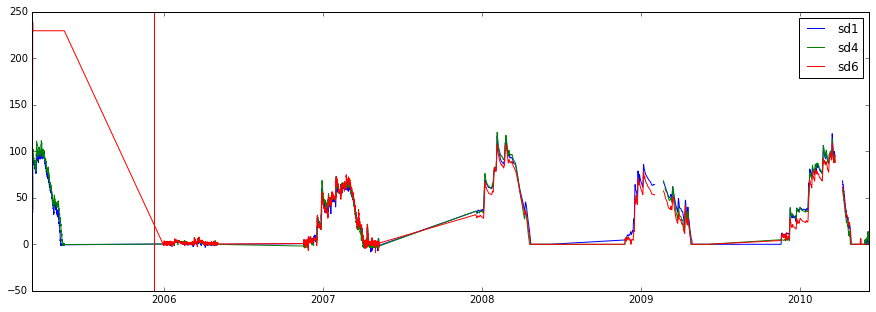

In [2]:
plt.figure(figsize=(15,5))
plt.plot(dat.sd1,label='sd1')
plt.plot(dat.sd4,label='sd4')
plt.plot(dat.sd6,label='sd6')
plt.legend(loc='upper right')
plt.axvline('2005-12-10',c='r')

In [3]:
dat.head()

,sd1,sd4,sd6
2005-03-05 17:00:00,28.5623,32.964967,41.4782
2005-03-05 18:00:00,28.8671,33.066567,41.5798
2005-03-05 19:00:00,28.6639,32.075967,41.6814
2005-03-05 20:00:00,28.6639,32.075967,181.3560
2005-03-05 21:00:00,28.5623,32.075967,175.7426


In [4]:
strt = '2005-03-05 17:00:00'
nd = '2005-12-10'

dat.loc[strt:nd,'sd6'] = np.NaN

In [5]:
dat2 = pd.rolling_mean(dat,window=6,center=True)

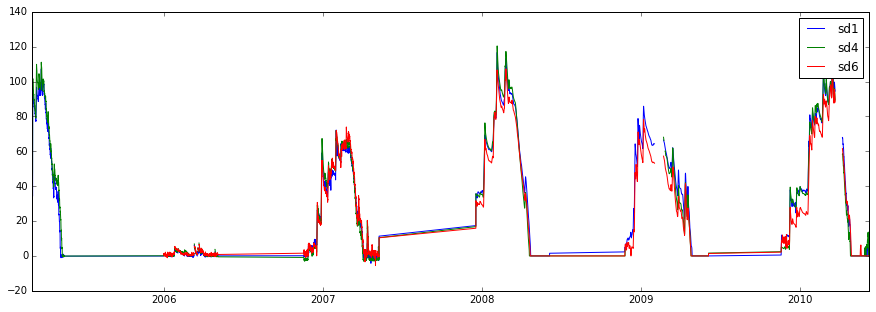

In [6]:
plt.figure(figsize=(15,5))
plt.plot(dat2.sd1,label='sd1')
plt.plot(dat2.sd4,label='sd4')
plt.plot(dat2.sd6,label='sd6')
plt.legend(loc='upper right')

In [7]:
# compute changes in snow depth

dat3 = pd.DataFrame()
for key in ['sd1','sd4','sd6']:
    tmp = dat2[key].as_matrix()
    
    dat3[key] = tmp[1:] - tmp[0:-1]

dat3.index = dat2.index[0:-1]

(0, 10)

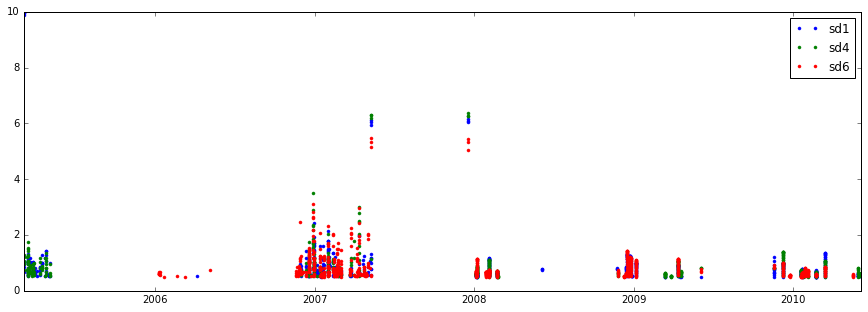

In [10]:
plt.figure(figsize=(15,5))
plt.plot(dat3.sd1,'.',label='sd1')
plt.plot(dat3.sd4,'.',label='sd4')
plt.plot(dat3.sd6,'.',label='sd6')
plt.legend(loc='upper right')
plt.ylim(0,10)

In [11]:
# remove small accumulation events as in Perrot et al. 2012

thresh = 0.5

dat3.loc[dat3.sd1<thresh,'sd1'] = np.NaN
dat3.loc[dat3.sd4<thresh,'sd4'] = np.NaN
dat3.loc[dat3.sd6<thresh,'sd6'] = np.NaN

In [12]:
def compute_ns_density(tw):
    '''compute new snow density based on the wet bulb temperature during snowfall.
    
    From Anderson 1976 (snow17) found in Perrot et al. 2012
    
    Returns density in g cm^-3'''
    
    tw += 273.15 # convert c to k
    
    rho_ns = 0.05 + 0.0017*((tw-258.16)**1.5)
    
    rho_ns *=1000. # g/cm3 to kg/m3
    
    return rho_ns

In [13]:
met = pd.read_pickle('./data/vcm_hourly_from_raws.pcl')

In [14]:
met['rho_ns'] = met.Tw.map(compute_ns_density)

In [15]:
datmin = dat3.index.min()
datmax = dat3.index.max()

In [16]:
met = met[datmin:datmax]

In [63]:
dat4 = pd.merge(left=dat3,right=met,left_index=True, right_index=True,how='outer')

In [99]:
dat4.head(10)

,sd1,sd4,sd6,AT,RH,TD,Tw,rho_ns,p1,p4,p6,P
2005-03-05 17:00:00,NaN,NaN,NaN,3.039884,100.000000,5.708839,-1.339298,135.739586,NaN,NaN,NaN,NaN
2005-03-05 18:00:00,NaN,NaN,NaN,2.328683,100.000000,4.439852,-2.055552,129.080746,NaN,NaN,NaN,NaN
2005-03-05 19:00:00,NaN,NaN,NaN,1.464942,100.000000,2.865035,-2.925430,121.238813,NaN,NaN,NaN,NaN
2005-03-05 20:00:00,NaN,NaN,NaN,0.507525,100.000000,1.078193,-3.889652,112.871496,NaN,NaN,NaN,NaN
2005-03-05 21:00:00,NaN,NaN,NaN,-0.478323,97.605035,-0.810825,-4.892369,104.547919,NaN,NaN,NaN,NaN
2005-03-05 22:00:00,NaN,0.749300,NaN,-1.425417,91.160776,-2.680099,-5.853062,96.951547,NaN,0.072646,NaN,0.072646
2005-03-05 23:00:00,25.598967,1.214967,NaN,-2.269215,85.308075,-4.400619,-6.682589,90.704971,NaN,0.110204,NaN,0.110204
2005-03-06 00:00:00,1.032933,1.265767,NaN,-5.113531,100.000000,-4.239214,-9.550697,71.565714,0.073923,0.090585,NaN,0.082254
2005-03-06 01:00:00,1.016000,0.999067,NaN,-5.684163,100.000000,-5.118291,-10.125391,68.239830,0.069332,0.068176,NaN,0.068754
2005-03-06 02:00:00,0.948267,0.969433,NaN,-5.975458,100.000000,-5.611459,-10.418761,66.614978,0.063169,0.064579,NaN,0.063874


In [65]:
def compute_p_sd1(df):
    s = df.sd1
    
    return s * (df.rho_ns/1000.)

def compute_p_sd4(df):
    s = df.sd4
    
    return s * (df.rho_ns/1000.)

def compute_p_sd6(df):
    s = df.sd6
    
    return s * (df.rho_ns/1000.)

In [66]:
dat4['p1'] = dat4.apply(compute_p_sd1,axis=1)
dat4['p4'] = dat4.apply(compute_p_sd4,axis=1)
dat4['p6'] = dat4.apply(compute_p_sd6,axis=1)

In [67]:
def average_p(df):
    return np.nanmean([df.p1,df.p4,df.p6])

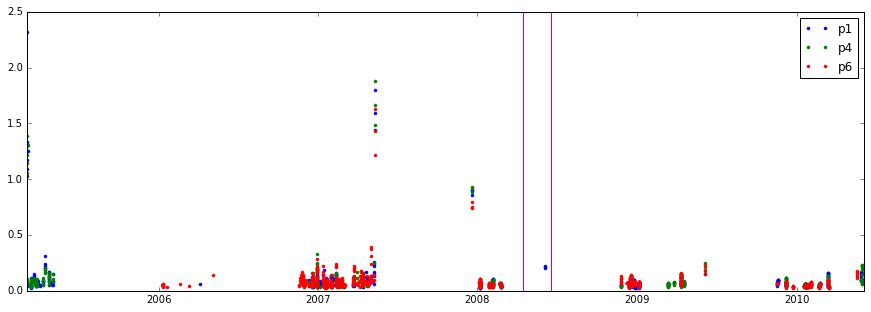

In [68]:
plt.figure(figsize=(15,5))
plt.plot(dat4.p1,'.',label='p1')
plt.plot(dat4.p4,'.',label='p4')
plt.plot(dat4.p6,'.',label='p6')
plt.legend(loc='upper right')
plt.ylim(0,2.5)
#plt.xlim('2008-3-15','2008-12-15')

strt = '2008-4-15'
nd = '2008-6-17'
plt.axvline(strt,c='m')
plt.axvline(nd,c='m')


In [69]:
dat4.loc[dat4.p1>0.7,'p1'] = np.NaN
dat4.loc[dat4.p4>0.7,'p4'] = np.NaN
dat4.loc[dat4.p6>0.7,'p6'] = np.NaN

In [70]:
dat4.columns

Index([u'sd1', u'sd4', u'sd6', u'AT', u'RH', u'TD', u'Tw', u'rho_ns', u'p1',
       u'p4', u'p6'],
      dtype='object')

In [71]:
dat4.loc[strt:nd,'p1'] = np.NaN

In [72]:
dat4['P'] = dat4.apply(average_p,axis=1)

In [104]:
new_met = pd.DataFrame({'P':dat4.resample('D',how='sum').P,
                        'Tmax':dat4.resample('D',how='max').AT,
                        'Tave':dat4.resample('D',how='mean').AT,
                        'Tmin':dat4.resample('D',how='min').AT})

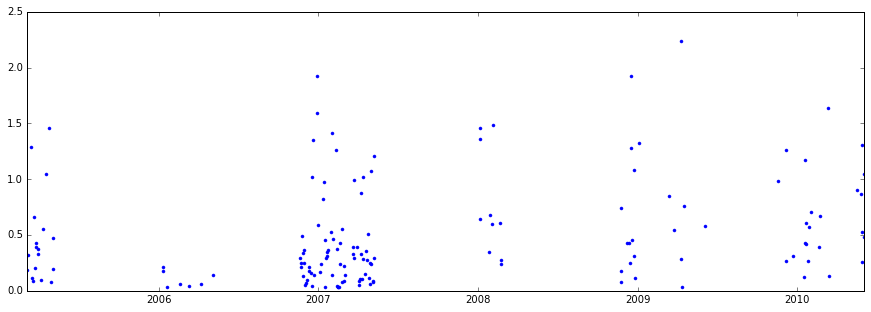

In [105]:
plt.figure(figsize=(15,5))
plt.plot(new_met.P,'.')

In [106]:
import rhessys.utilities as rut

In [107]:
new_met['wateryear'] = new_met.index.map(rut.wateryear)

In [108]:
# fill nans with zeros

new_met.loc[np.isnan(new_met.P),'P'] = 0.

In [109]:
# convert P from cm to m
new_met.P /= 100.

In [110]:
new_met['cumulative_P'] = new_met.groupby('wateryear').P.cumsum()

In [111]:
new_met.head()

,P,Tave,Tmax,Tmin,wateryear,cumulative_P
2005-03-05,0.001828,0.452583,3.039884,-2.269215,2005,0.001828
2005-03-06,0.003242,-1.585223,2.805013,-5.975458,2005,0.005071
2005-03-07,0.000000,0.377038,9.371262,-8.617186,2005,0.005071
2005-03-08,0.000000,2.223994,10.415117,-5.967130,2005,0.005071
2005-03-09,0.000000,2.049387,11.938433,-7.839660,2005,0.005071


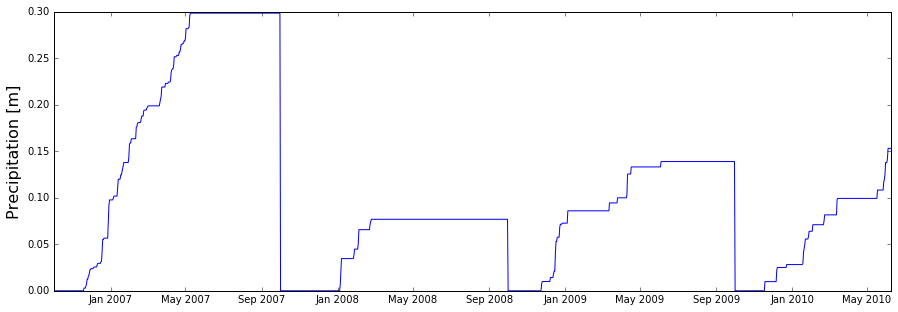

In [114]:
plt.figure(figsize=(15,5))
plt.plot(new_met.cumulative_P,'-')
plt.ylabel('Precipitation [m]', fontsize=16)

In [113]:
# crop to WY2007-WY2009

strt = '2006-10-01'
nd = '2010-09-30'

new_met = new_met[strt:nd].copy()

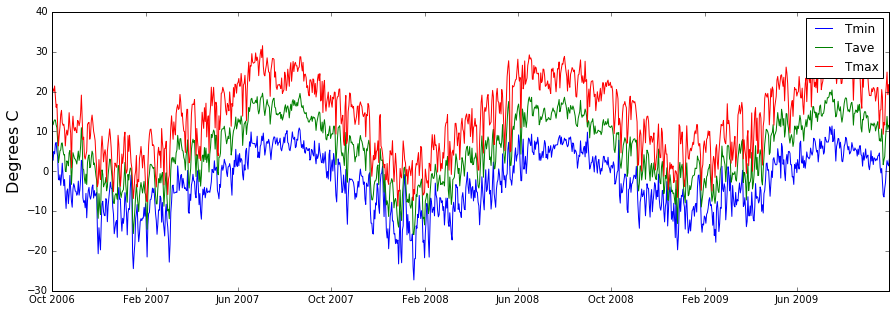

In [102]:
plt.figure(figsize=(15,5))
plt.plot(new_met.Tmin,'-',label='Tmin')
plt.plot(new_met.Tave,'-',label='Tave')
plt.plot(new_met.Tmax,'-',label='Tmax')
plt.legend()
plt.ylabel('Degrees C', fontsize=16)

In [94]:
print new_met.index.min()
print new_met.index.max()

dt = new_met.index.min()

2005-03-05 00:00:00
2010-06-08 00:00:00


In [95]:
header = '%s %s %s'%(dt.year,dt.month,dt.day)

In [97]:
np.savetxt('/RHESSys/jemez/clim/vcm_sd.rain',new_met.P,header=header,comments='',fmt='%f')
np.savetxt('/RHESSys/jemez/clim/vcm_sd.tmin',new_met.Tmin,header=header,comments='',fmt='%f')
np.savetxt('/RHESSys/jemez/clim/vcm_sd.tave',new_met.Tave,header=header,comments='',fmt='%f')
np.savetxt('/RHESSys/jemez/clim/vcm_sd.tmax',new_met.Tmax,header=header,comments='',fmt='%f')